# Gilbert

Import libraries we need. Networkx is used for random graphs, while numpy is for calculations and pyplot is for visualisation.

In [ ]:
from matplotlib import pyplot as plt
from scipy.special import comb
from datetime import datetime
import networkx as nx
import numpy as np
import math

To select GPU processing go to Edit -> Notebook Settings. Using a GPU instead of a CPU is the main feature of Google Colab and will speed up the computation significantly. The following code checks if the allocation was successful.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Examples

Let's test the library for random graph generation. The erdos_renyi_graph generates a Gilbert random graph, and only requires n and p to be specified. We can view the graph via the draw function.

Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(0, 3), (0, 4), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (2, 3), (2, 4), (2, 5), (2, 8), (3, 7), (3, 8), (4, 5), (4, 6), (4, 9), (5, 6), (6, 7), (6, 9)]


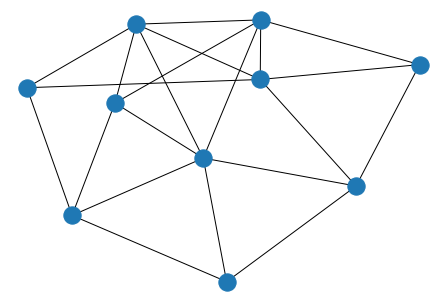

In [ ]:
n = 10
p = 0.3
# Other generators: https://networkx.org/documentation/networkx-1.10/reference/generators.html
g = nx.erdos_renyi_graph(n, p)
print("Nodes:", g.nodes)
print("Edges:", g.edges)
nx.draw(g)

## APL


Luckily the formula for average path lengths is also in the library. Although it throws an error in case the graph is not connected, we can workaround this if needed. As $n \rightarrow \infty$ this shoud not be a problem anyway.


The formula used is: $a = \sum\limits_{s,t \in V}\frac{d(s,t)}{n(n-1)}$


In [ ]:
# Throws an error if the graph is not connected
# https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html

# For disconnected graphs you can compute the average shortest path length for each component: >>> G=nx.Graph([(1,2),(3,4)]) >>> for g in nx.connected_component_subgraphs(G): 
nx.average_shortest_path_length(g)

1.7555555555555555

In [ ]:
def connected_component_subgraphs(G):
  for c in nx.connected_components(G):
      yield G.subgraph(c)

We now define a few network sizes and probabilities, then generate a random graph and calculate its APL.

In [ ]:
ks = [4, 7, 10, 20, 30]
APL = []
network_sizes = [100, 500, 1000, 1500, 2000, 3000, 5000, 10000]

for k in ks:
  apl = []
  for n in network_sizes:
    p = k / (n-1)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(k, p, n, current_time)
    G = nx.erdos_renyi_graph(n, p)
    try:
      apl.append(nx.average_shortest_path_length(G))
    except nx.NetworkXError:
      apl.append(0)
  APL.append(apl)

4 0.04040404040404041 100 10:00:23
4 0.008016032064128256 500 10:00:23
4 0.004004004004004004 1000 10:00:23
4 0.00266844563042028 1500 10:00:23
4 0.002001000500250125 2000 10:00:23
4 0.001333777925975325 3000 10:00:23
4 0.0008001600320064013 5000 10:00:24
4 0.00040004000400040005 10000 10:00:25
7 0.0707070707070707 100 10:00:30
7 0.014028056112224449 500 10:00:30
7 0.007007007007007007 1000 10:00:31
7 0.004669779853235491 1500 10:00:32
7 0.003501750875437719 2000 10:00:32
7 0.002334111370456819 3000 10:00:32
7 0.0014002800560112022 5000 10:00:33
7 0.0007000700070007 10000 10:00:34
10 0.10101010101010101 100 10:00:39
10 0.02004008016032064 500 10:00:39
10 0.01001001001001001 1000 10:00:39
10 0.0066711140760507 1500 10:00:40
10 0.0050025012506253125 2000 10:00:43
10 0.003334444814938313 3000 10:00:49
10 0.002000400080016003 5000 10:01:00
10 0.001000100010001 10000 10:01:32
20 0.20202020202020202 100 10:01:37
20 0.04008016032064128 500 10:01:37
20 0.02002002002002002 1000 10:01:37
20 0.01

APL_analytic will return the predicted value of the average path length as in Fronzcak.

In [ ]:
def APL_analytic(n, k):
  return (
      ((np.log(n) - np.euler_gamma) / (np.log(k))) + 0.5
  )

First calculate the predicted APL for a few network sizes and the same probabilities as above. Then plot everything with pyplot.

In [ ]:
sizes = np.linspace(start = network_sizes[0], stop = network_sizes[-1], num = 200)
APL_analytic_values = []
for k in ks:
  APL_analytic_values.append([APL_analytic(round(s), k) for s in sizes])

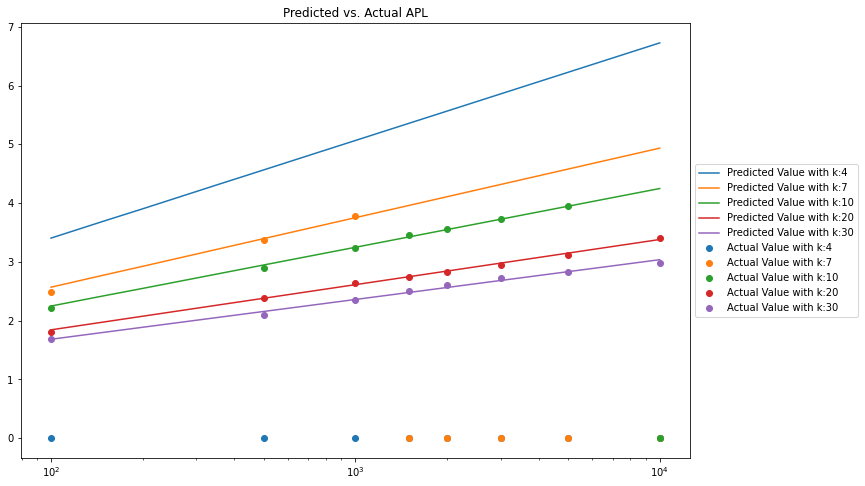

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
# Plot
for i in range(len(ks)):
  plt.plot(sizes, APL_analytic_values[i], label="Predicted Value with k:" + str(ks[i]))
  plt.scatter(y=APL[i], x=network_sizes, label="Actual Value with k:" + str(ks[i]))

plt.xscale('log')
plt.title("Predicted vs. Actual APL")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Gilbert connectivity recurrence



Let $P_n$ denote the probability that a gilbert graph is connected, and let $R_n$ denote the probability that two arbitrary vertices in the gilbert graph are connected, then by Gilbert original paper:

$$
 1- P_n = \sum_{m=1}^{n-1} \; {{n-1} \choose {m-1}}P_m \; q^{m(n-m)}
$$

and

$$
 1- R_n = \sum_{m=1}^{n-1} \; {{n-2} \choose {m-1}}P_m \; q^{m(n-m)}
$$

We define these recurrence relations in Python, by recursion. Note this is incredibly inefficient, and could be sped up by any dynamic programming principle.

In [ ]:
def P(n, q):
  if n == 0:
    return 1
  else:
    total = 0
    for k in range(1, n):
      total += comb((n-1), (k-1)) * P(k, q) * q**(k*(n - k))
    return 1 - total

def R(n, q):
  if n == 0:
    return 1
  else:
    total = 0
    for k in range(1, n):
      total += comb((n-2), (k-1)) * P(k, q) * q**(k*(n - k))
    return 1 - total

Carry out the experiment.

In [ ]:
Ps = []
Rs = []
qs = [0.1, 0.3, 0.5, 0.7, 0.9]
LIM = 20

for q in qs:
  print(q)
  temp_Ps = []
  temp_Rs = []
  for n in range(LIM):
    temp_Ps.append(P(n, q))
    temp_Rs.append(R(n, q))
  Ps.append(temp_Ps)
  Rs.append(temp_Rs)

0.1
0.3
0.5
0.7
0.9


Gilbert also shows that 

$ P_n = 1 - nq^{n-1} + O(n^2 q^{\frac{3n}{2}})$ and $R_n = 1 - 2 q^{n-1} + O(n^2 q^{\frac{3n}{2}})$. Which for large enough $n$ (depending on $q$) they can be approximated by:

\begin{align}
    P_n \approx 1 - nq^{n-1} \quad \text{and} \quad R_n \approx 1 - 2 \cdot q^{n-1}
\end{align}

In [ ]:
def approx_pn(n, q):
  return 1 - n*q**(n-1)

approx_ps = []
for q in qs:
  temp = []
  for n in range(LIM):
    temp.append(approx_pn(n, q))
  approx_ps.append(temp)

In [ ]:
def approx_rn(n, q):
  return 1 - 2*q**(n-1)

approx_rs = []
for q in qs:
  temp = []
  for n in range(LIM):
    temp.append(approx_rn(n, q))
  approx_rs.append(temp)

Plot all of them.

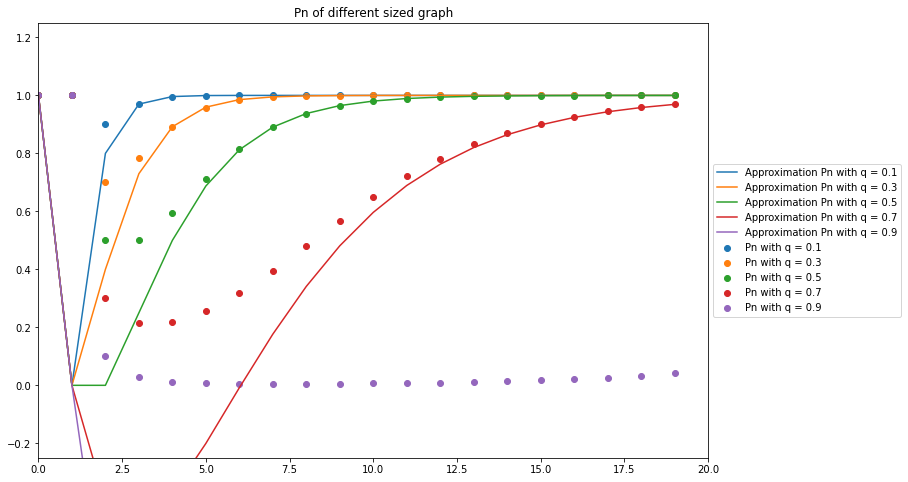

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
x_axis = [i for i in range(LIM)]
plt.xlim([0,20])
plt.ylim([-0.25, 1.25])
# Plot
for i in range(len(qs)):
  plt.scatter(x_axis, Ps[i], label = "Pn with q = " + str(qs[i]))
  plt.plot(approx_ps[i], label = "Approximation Pn with q = " + str(qs[i]))
  #plt.plot(Ps[i])


plt.title("Pn of different sized graph")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

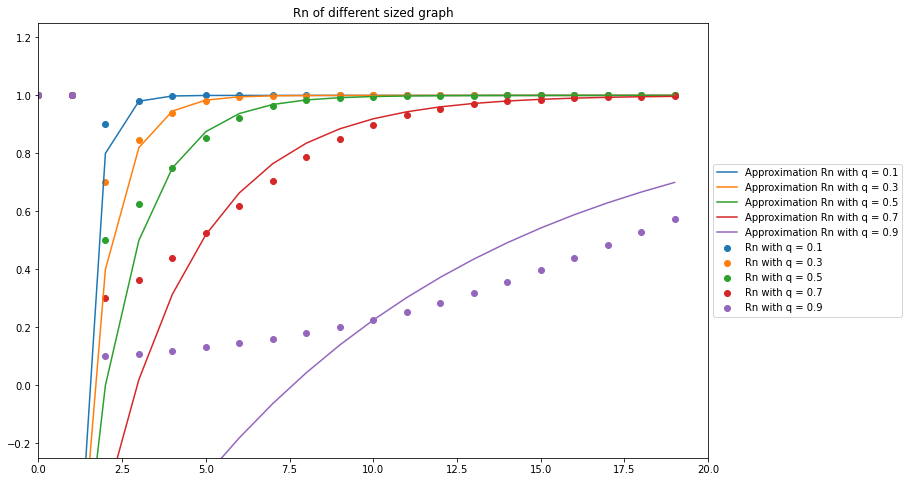

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
x_axis = [i for i in range(20)]
plt.xlim([0,20])
plt.ylim([-0.25, 1.25])
# Plot
for i in range(len(qs)):
  plt.scatter(x_axis, Rs[i], label = "Rn with q = " + str(qs[i]))
  plt.plot(approx_rs[i], label = "Approximation Rn with q = " + str(qs[i]))
  #plt.plot(Rs[i])

plt.title("Rn of different sized graph")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()